In [59]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [89]:
@partial(jax.jit, static_argnums=(2, 3))
def linear_ma(pos : jnp.ndarray, weight : jnp.ndarray, grid_size : int, dx : float) -> jnp.ndarray:

    coords = jnp.linspace(start=0, stop=1, num=grid_size+1)

    grid = jnp.zeros((grid_size, grid_size, grid_size))

    # find position on the grid
    x_idx = jnp.digitize(pos[0] % 1.0, coords, right=True) - 1
    y_idx = jnp.digitize(pos[1] % 1.0, coords, right=True) - 1
    z_idx = jnp.digitize(pos[2] % 1.0, coords, right=True) - 1

    # assign the mass
    grid = grid.at[x_idx, y_idx, z_idx].add(weight / dx**3)

    return grid

In [90]:
def central_difference(
        field : jnp.ndarray,
        axis : int, 
        delta : float) -> jnp.ndarray:
    
    field_r = jnp.roll(field, 1, axis=axis)
    field_l = jnp.roll(field, -1, axis=axis)
    return (field_r - 2 * field + field_l) / (delta ** 2)

In [91]:
def gradient(
        field : jnp.ndarray,
        delta : float) -> jnp.ndarray:
    
    grad_x = central_difference(field, 0, delta)
    grad_y = central_difference(field, 1, delta)
    grad_z = central_difference(field, 2, delta)

    return jnp.stack([grad_x, grad_y, grad_z], axis=0)

In [92]:
def linear_interp(pos : jnp.ndarray, grid : jnp.ndarray, dx : float) -> jnp.ndarray:

    coords = jnp.linspace(start=0, stop=1, num=grid.shape[0])

    # find position on the grid
    x_idx = jnp.digitize(pos[0] % 1.0, coords, right=True) - 1
    y_idx = jnp.digitize(pos[1] % 1.0, coords, right=True) - 1
    z_idx = jnp.digitize(pos[2] % 1.0, coords, right=True) - 1

    # find the weights
    x_w = (pos[0] % 1.0 - coords[x_idx]) / dx
    y_w = (pos[1] % 1.0 - coords[y_idx]) / dx
    z_w = (pos[2] % 1.0 - coords[z_idx]) / dx

    # perform the interpolation
    interp = grid[x_idx, y_idx, z_idx] * (1 - x_w) * (1 - y_w) * (1 - z_w) + \
             grid[x_idx + 1, y_idx, z_idx] * x_w * (1 - y_w) * (1 - z_w) + \
             grid[x_idx, y_idx + 1, z_idx] * (1 - x_w) * y_w * (1 - z_w) + \
             grid[x_idx + 1, y_idx + 1, z_idx] * x_w * y_w * (1 - z_w) + \
             grid[x_idx, y_idx, z_idx + 1] * (1 - x_w) * (1 - y_w) * z_w + \
             grid[x_idx + 1, y_idx, z_idx + 1] * x_w * (1 - y_w) * z_w + \
             grid[x_idx, y_idx + 1, z_idx + 1] * (1 - x_w) * y_w * z_w + \
             grid[x_idx + 1, y_idx + 1, z_idx + 1] * x_w * y_w * z_w

    return interp

In [93]:
@jax.jit
def step(
        params,
        grid_star : jnp.ndarray,
        dx : float,
        rate : float):
        
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = linear_ma(pos, weight, grid_size, dx)

    # define the loss surface
    field = (grid_star - grid)

    # get the gradient grid
    grad_field = gradient(field, dx)

    grad_pos_x = linear_interp(
        pos, 
        grad_field[0], 
        dx)
    
    grad_pos_y = linear_interp(
        pos, 
        grad_field[1], 
        dx)
    
    grad_pos_z = linear_interp(
        pos, 
        grad_field[2], 
        dx)
    
    grad_pos = jnp.stack([
        grad_pos_x, grad_pos_y, grad_pos_z])

    params["pos"] = pos + rate * grad_pos

    return params


In [94]:
def mse(params, grid_star : jnp.ndarray):
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = linear_ma(pos, weight, grid_size, dx)

    return jnp.mean((grid_star - grid)**2)
        
def optimize(
        params, 
        grid_star : jnp.ndarray, 
        dx : float, 
        n_steps : int,
        rate : float) -> jnp.ndarray:
    
    for i in range(n_steps):
        params = step(params, grid_star, dx, rate)
        print(f"mse : {mse(params, grid_star)}")

    return params


In [98]:
N = 10000
grid_size = 10
dx = 1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
weight = jax.random.uniform(key_weight, (N,)) / (grid_size ** 3)

# assign particles 
grid_star = linear_ma(pos, weight, grid_size, dx)

print(grid_star.mean())

0.0049868785


In [96]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

pos = jax.random.uniform(key_pos, (3, N)) 
weight = jax.random.uniform(key_weight, (N, )) / grid_size ** 3

params_init = {
    'pos' : pos,
    'weight' : weight}

params = optimize(params_init, grid_star, dx, 100, 0.01)

/home/andrin/miniconda3/envs/ml-env/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/andrin/miniconda3/envs/ml-env/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


mse : 6.671736173302634e-06
mse : 6.648554972343845e-06
mse : 6.656699952145573e-06
mse : 6.642366315645631e-06
mse : 6.639019829890458e-06
mse : 6.625261903536739e-06
mse : 6.582267360499827e-06
mse : 6.575419774890179e-06
mse : 6.566356205439661e-06
mse : 6.528896392410388e-06
mse : 6.539516562042991e-06
mse : 6.51842219667742e-06
mse : 6.503144049929688e-06
mse : 6.498393759102328e-06
mse : 6.484910954895895e-06
mse : 6.4753921833471395e-06
mse : 6.451245553762419e-06
mse : 6.464076705015032e-06
mse : 6.449095053540077e-06
mse : 6.447223768191179e-06
mse : 6.4161172304011416e-06
mse : 6.40960161035764e-06
mse : 6.4137943809328135e-06
mse : 6.378299985954072e-06
mse : 6.38291567156557e-06
mse : 6.365000444930047e-06
mse : 6.332366865535732e-06
mse : 6.324913556454703e-06
mse : 6.312261120910989e-06
mse : 6.2694830376130994e-06
mse : 6.221565399755491e-06
mse : 6.2195126702135894e-06
mse : 6.2103404161462095e-06
mse : 6.176956503622932e-06
mse : 6.165957984194392e-06
mse : 6.155635674

[[0.79275846 0.59061176 0.6681773  ... 0.26501286 0.880267   0.43461013]
 [0.51213604 0.47315934 0.56227136 ... 0.9643921  0.50486463 0.15707381]
 [0.91435456 0.9405014  0.08865481 ... 0.75836676 0.47183287 0.6576751 ]]


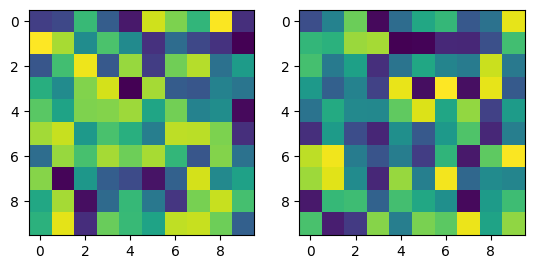

In [86]:

print(params["pos"])

grid = linear_ma(params["pos"], params["weight"], grid_size, 0.1)

# plot side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grid_star[grid_size // 2, :, :])
plt.subplot(1, 2, 2)
plt.imshow(grid[grid_size // 2, :, :])
plt.show()